# What is the impact of Minimum Wage laws on Employment Rates?
Given the intensity of the minimum wage (measured in relation to local GDP per Capita), what does the Employment Rate of that country looks like?

We'll analyze only the latest number available for simplicity sake. Though a deeper analysis (using a time-series) would obviously yield clearer results.

Sources:
- A) https://en.wikipedia.org/wiki/List_of_countries_by_minimum_wage
- B) https://databank.worldbank.org/reports.aspx?source=2&series=SL.EMP.WORK.ZS&country=#

In [14]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

In [15]:
df_employ = pd.read_csv('../Data_Sets/originalData/99_employment_data.csv')
df_minWage = pd.read_csv('../Data_Sets/originalData/99_minimumWage.csv')

## Cleaning Data Sets

### Renaming countries

In [16]:
country_name_mapping = {
    'Bahamas, The': 'The Bahamas',
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Venezuela, RB': 'Venezuela',
    'Viet Nam': 'Vietnam',
    'Turkiye': 'Turkey',
    'Gambia, The': 'The Gambia',
    'Yemen, Rep.': 'Yemen',
    'Cabo Verde': 'Cape Verde',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    'Egypt, Arab Rep.': 'Egypt',
    'Czechia': 'Czech Republic',
    'Micronesia, Fed. Sts.': 'Federated States of Micronesia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macau',
    "Korea, Dem. People's Rep.": 'North Korea',
    'Korea, Rep.': 'South Korea',
    'Iran, Islamic Rep.': 'Iran',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Brunei Darussalam': 'Brunei',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Sao Tome and Principe': 'São Tomé and Príncipe'
}

# Use apply with lambda to update 'Country Name' column
df_employ['Country Name'] = df_employ['Country Name'].apply(lambda x: country_name_mapping.get(x, x))

### Verifying Names before merge
Using some set algebra, we can see if there's any country in one data set that is not in the other. And also check if there's any name we should manually fix.

In [17]:
A = set(df_employ['Country Name'])
B = set(df_minWage['Country'])

C1 = A - B
C2 = B - A
C = set(list(C1) + list(C2))
C

{'American Samoa',
 'Argentina',
 'Aruba',
 'Bermuda',
 'British Virgin Islands',
 'Cayman Islands',
 'Channel Islands',
 'Curacao',
 'Faroe Islands',
 'French Polynesia',
 'Gibraltar',
 'Greenland',
 'Guam',
 'Guernsey',
 'Jersey',
 'New Caledonia',
 'Northern Cyprus',
 'Northern Mariana Islands',
 'Palestine',
 'Puerto Rico',
 'Sint Maarten (Dutch part)',
 'St. Martin (French part)',
 'Taiwan',
 'Turkmenistan',
 'Turks and Caicos Islands',
 'Virgin Islands (U.S.)',
 'West Bank and Gaza',
 nan}

### Deleting countries only present in one of the datasets

In [18]:
countries_to_delete = list(C)
df_employ = df_employ[~df_employ['Country Name'].isin(countries_to_delete)]

df_minWage = df_minWage[~df_minWage['Country'].isin(countries_to_delete)]

### Dealing with missing values

In [19]:
df_employ.replace("..", np.nan, inplace=True)


df_employ.dropna(subset=['2019 [YR2019]'], inplace=True)

# rotating the Data Frame for easier interpolation
df_employ_long = pd.melt(df_employ, 
                         id_vars=['Country Name'], 
                         value_vars=['1990 [YR1990]', '2000 [YR2000]', '2013 [YR2013]', '2014 [YR2014]', 
                                     '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', 
                                     '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]'],
                         var_name='Index Year', 
                         value_name='Emp_Rate')

# Cleaning the 'Index Year' to keep only the year part
df_employ_long['Index Year'] = df_employ_long['Index Year'].str.extract('(\d{4})')

# Getting the latest Employment Rate statistic
df_employ_filled = df_employ_long.groupby('Country Name', as_index=False).apply(lambda group: group.ffill())
df_employ_filled.reset_index(drop=True, inplace=True)


df_employ_latest = df_employ_filled[df_employ_filled['Index Year'] == "2022"].dropna()[['Country Name','Emp_Rate']]
df_employ_latest['Emp_Rate'] = df_employ_latest['Emp_Rate'].astype('float')

In [20]:
df_minWage_2 = df_minWage[['Country', r"% of GDP per capita"]].dropna()

# Removing the '%' sign and converting the column to float
df_minWage_2['% of GDP per capita'] = df_minWage_2['% of GDP per capita'].str.replace('%', '').astype(float)/100

df_minWage_2.head(2)

,Country,% of GDP per capita
0,Central African Republic,2.203
1,Comoros,1.995


### Doing the actual merge

In [21]:
df = df_employ_latest.merge(df_minWage_2,how="left",left_on="Country Name", right_on="Country")

df = df[["Country Name", "Emp_Rate",r"% of GDP per capita"]].dropna()

## Data Visualization

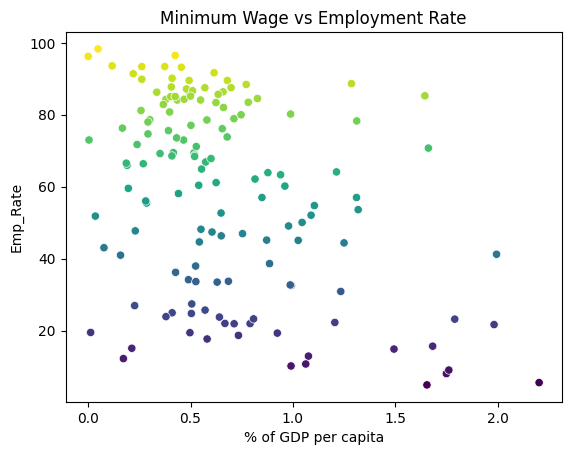

In [24]:
sns.scatterplot(x=r'% of GDP per capita', y='Emp_Rate', hue='Emp_Rate', data=df, legend=False, palette='viridis')
plt.title('Minimum Wage vs Employment Rate')
plt.show()